In [1]:
import sys

!{sys.executable} -m pip install --quiet matplotlib numpy

In [2]:
import torch
import torch.nn as nn
from typing import Tuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CharLSTM(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_size: int, n_layers: int, dropout: float):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0.0,
            batch_first=True,
        )
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def init_hidden(self, batch_size: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        h = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        c = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        return h, c

    def forward(self, x: torch.Tensor, hc: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        emb = self.embedding(x)
        out, (h, c) = self.lstm(emb, hc)
        out = self.drop(out)
        logits = self.fc(out)
        return logits, (h, c)


In [3]:
# Load checkpoint (si utilisation en local : LSTM_models/best_lstm_model.pt)
ckpt = torch.load("best_lstm_model.pt", map_location=device)

config = ckpt["config"]
char2idx = ckpt["char2int"]
vocab_size = ckpt["vocab_size"]

model = CharLSTM(
    vocab_size=vocab_size,
    embedding_dim=config["embedding_dim"],
    hidden_size=config["hidden_size"],
    n_layers=config["n_layers"],
    dropout=config["dropout"],
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("r2_local:", ckpt.get("r2_local"))
print("best_neuron:", ckpt.get("best_neuron"))
print("device:", next(model.parameters()).device)


/tmp/ipykernel_3256/3945470255.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_lstm_model.pt", map_location=device) #LSTM_models/best_lstm_model.

r2_local: 0.7363255060077168
best_neuron: 250
device: cuda:0


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def encode_string(s, char2idx):
    return torch.tensor(
        [char2idx[c] for c in s if c in char2idx],
        dtype=torch.long
    )

In [6]:
def extract_c250(model, s, char2idx, device=device):
    x = encode_string(s, char2idx).unsqueeze(0).to(device)
    emb = model.embedding(x)

    hx = torch.zeros(1, 1, model.hidden_size, device=device)
    cx = torch.zeros(1, 1, model.hidden_size, device=device)

    c_vals = []
    for t in range(emb.size(1)):
        _, (hx, cx) = model.lstm(emb[:, t:t+1, :], (hx, cx))
        c_vals.append(cx[0, 0, 250].item())

    return c_vals

In [7]:
s_paren = "abc (def ghi) jkl"
s_brack = "abc [def ghi] jkl"

c_paren = extract_c250(model, s_paren, char2idx)
c_brack = extract_c250(model, s_brack, char2idx)

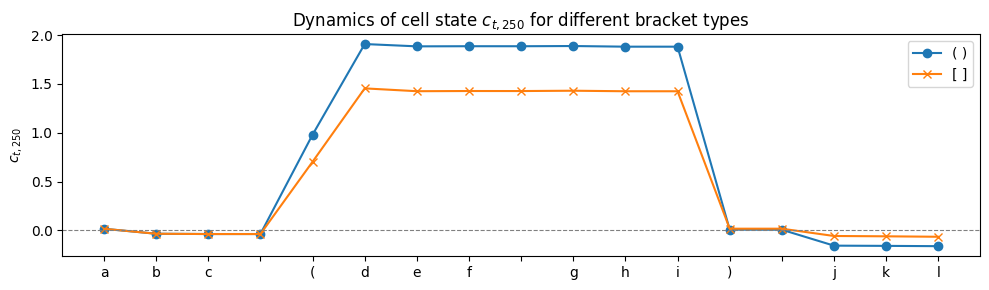

In [8]:
plt.figure(figsize=(10, 3))

plt.plot(c_paren, label="( )", marker="o")
plt.plot(c_brack, label="[ ]", marker="x")

plt.xticks(range(len(s_paren)), list(s_paren))
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)

plt.ylabel(r"$c_{t,250}$")
plt.title("Dynamics of cell state $c_{t,250}$ for different bracket types")
plt.legend()
plt.tight_layout()
plt.show()